<a href="https://colab.research.google.com/github/karolinakuligowska/TMSMM_codes/blob/main/TMSMM_class12_RNN_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(dplyr)
library(ggplot2)
library(purrr)
library(readr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [4]:
library(keras)
library(tensorflow)
library(reticulate)

In [5]:
# 1. Load dataset ----

df <- read_csv('movie_review.csv')
head(df)

Rows: 64720 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): cv_tag, html_id, text, tag
dbl (2): fold_id, sent_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fold_id,cv_tag,html_id,sent_id,text,tag
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
0,cv000,29590,0,"films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before .",pos
0,cv000,29590,1,"for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen .",pos
0,cv000,29590,2,to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd .,pos
0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes .",pos
0,cv000,29590,4,"in other words , don't dismiss this film because of its source .",pos
0,cv000,29590,5,"if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes .",pos


In [14]:
# 2. Explore the data ----

df %>% count(tag)

tag,n
<chr>,<int>
neg,31783
pos,32937


In [15]:
df$text[1]

[1] "films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before ."

In [16]:
training_id <- sample.int(nrow(df), size = nrow(df)*0.8)
training <- df[training_id,]
testing <- df[-training_id,]

In [17]:
# find out what is the distribution
# of the number of words in each review
df$text %>%
  strsplit(" ") %>%
  sapply(length) %>%
  summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   14.00   21.00   23.06   30.00  179.00 

In [18]:
# 3. Prepare the data ----

# the text — must be converted to tensors
# before fed into the neural network

num_words <- 10000
max_length <- 50
text_vectorization <- layer_text_vectorization(
  max_tokens = num_words,
  output_sequence_length = max_length,
)

In [19]:
# Now, adapt the Text Vectorization layer.
# When we call adapt that the layer will learn
# about unique words in our dataset and assign an integer value for each one.

text_vectorization %>%
  adapt(df$text)

In [20]:
# The vocabulary is in our text vectorization layer
# see first 10 words
get_vocabulary(text_vectorization) %>% head(10)

[1] ""      "[UNK]" "the"   "a"     "and"   "of"    "to"    "is"    "in"   
[10] "that"

In [21]:
# See how the text vectorization layer transforms it’s inputs:
text_vectorization(matrix(df$text[1], ncol = 1))

tf.Tensor(
[[  68 2835   30  359 1662   33   91 1056    5  632  631  321   41 7803
   709 4865 1767   48 7600 1337  398 5161   48    2    1 1808 1800  148
    17  140  109   90   69    3  359  408   40   30  503  142    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)

In [22]:
# 4. Build the model ----

input <- layer_input(shape = c(1), dtype = "string")

output <- input %>%
  text_vectorization() %>%
  layer_embedding(input_dim = num_words + 1, output_dim = 16) %>%
  layer_global_average_pooling_1d() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 1, activation = "sigmoid")

model <- keras_model(input, output)

In [24]:
# 5. Hidden units ----

# This model has two intermediate or “hidden” layers,
# between the input and output.
# The number of outputs (units, nodes, or neurons)
# is the dimension of the representational space for the layer.
# In other words, the amount of freedom the network is allowed
# when learning an internal representation.



# 6. Loss function and optimizer ----

model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('accuracy')
)


In [25]:
# 7. Train the model ----

# Train the model for 20 epochs in mini-batches of 512 samples.


history <- model %>% fit(
  training$text,
  as.numeric(training$tag == "pos"),
  epochs = 20,
  batch_size = 512,
  validation_split = 0.2,
  verbose=2
)

In [26]:
# 8. Evaluate the model ----

results <- model %>%
  evaluate(testing$text, as.numeric(testing$tag == "pos"), verbose = 0)

results

# This naive approach achieves an accuracy of about 67-68%.
# With more advanced approaches,
# the model should get closer to 85%.

loss  accuracy 
0.6412032 0.6751391

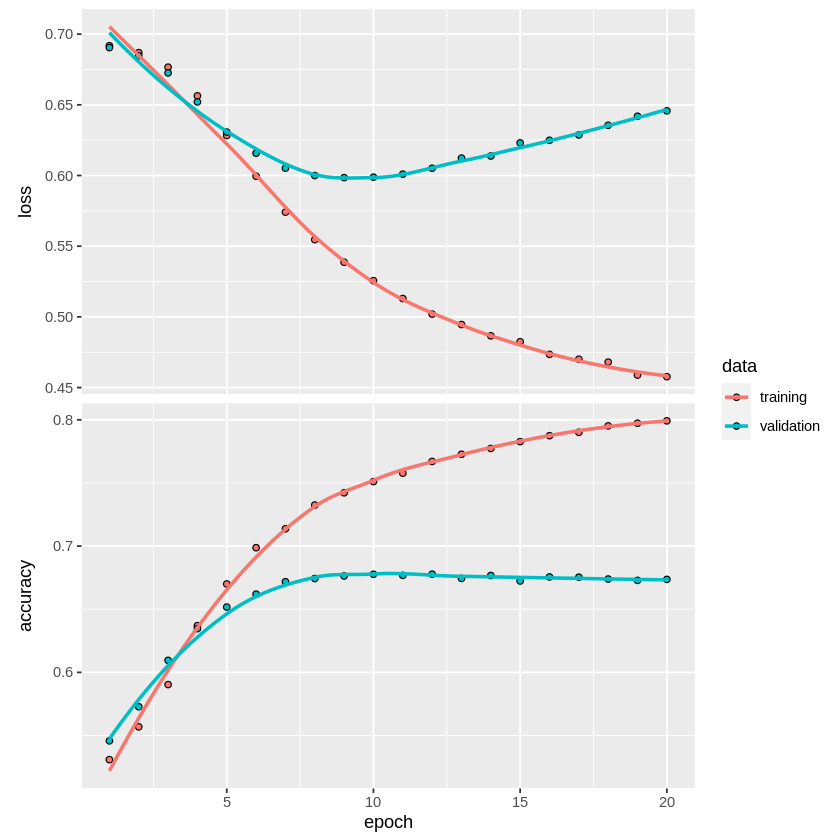

In [27]:
# graph of accuracy and loss over time
plot(history)

In [28]:
new_reviews <- c(
  "it was awesome!",
  "I watched with pleasure",
  "the screening was a disaster I was ashamed of quality",
  "a misunderstanding, weak story",
  "rubbish stupid movie"
)

new_reviews

[1] "it was awesome!"                                      
[2] "I watched with pleasure"                              
[3] "the screening was a disaster I was ashamed of quality"
[4] "a misunderstanding, weak story"                       
[5] "rubbish stupid movie"

In [29]:
predict(model, new_reviews)

0.7453844
0.4227466
0.3491215
0.2587469
0.1499337
